In [10]:
import cv2
import numpy as np
import scipy
from scipy.spatial import distance
#from scipy.misc import imread
import _pickle as cPickle
#import cPickle as pickle
import pickle
import random
import os
import matplotlib.pyplot as plt
import skimage, imageio
from pathlib import Path

In [37]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imageio.imread(image_path)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

def extract_features_surf(image_path, vector_size=40):
    image = imageio.imread(image_path)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64) #2560
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [f for f in Path(images_path).glob('*dThickness.png')]
#     files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
#         f=str(f)
#         name = f.split('/')[-1].lower()
        name = os.path.basename(f)
        print("NAME :\n", name)
#         result[name] = extract_features(f)
        result[name] = extract_features_surf(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [35]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        print("Image Distance", img_distances)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()
    
    def match_threshold(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        print("Image Distance", img_distances)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearesimg_paths, img_distances[nearest_ids].tolist()

FILES: 
 [WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img12_CS_OP20_por_dt_06162020_forecast_00021 2013-07-02 to 2018-10-10  dThickness.png'), WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img16_CS_OP20_por_dt_06162020_forecast_00021 2013-07-02 to 2016-09-03  dThickness.png'), WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img4_CS_OP20_por_dt_06162020_forecast_00061 2013-07-02 to 2018-10-10  dThickness.png'), WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img8_CS_OP20_por_dt_06162020_forecast_00061 2013-07-02 to 2016-09-03  dThickness.png')]
sample :
 [WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img12_CS_OP20_por_dt_06162020_forecast_00021 2013-07-02 to 2018-10-10  dThickness.png'), WindowsPath('C:/Users/Prakalp.Somawanshi/Local Store/QRM/Projects/ImgCmp/Data/Seismic/Img16_CS_OP20_por_dt

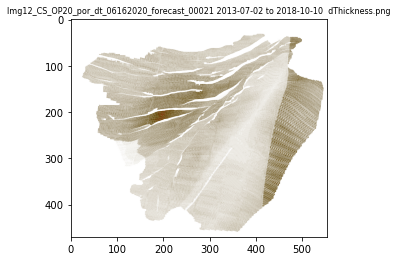


Result images ========================================


Match 1.0


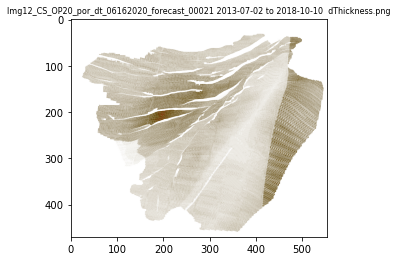


Match 0.7134370878980734


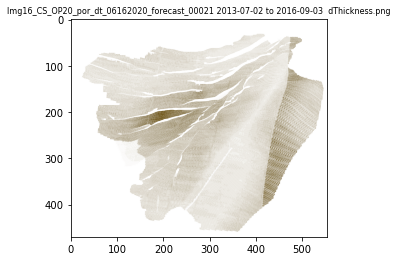


Match 0.7013794700519744


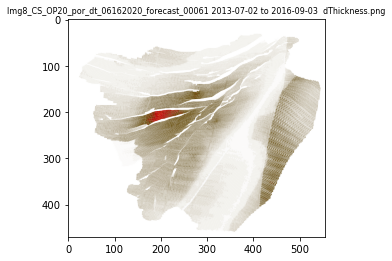


Match 0.7002146338748869


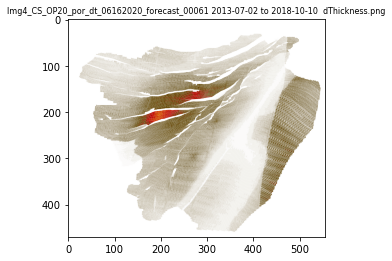

Image Distance [0.28656291 0.         0.27555499 0.28396612]

Query image ==========================================



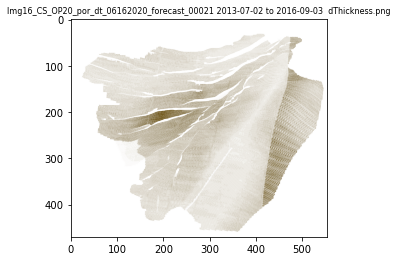


Result images ========================================


Match 1.0


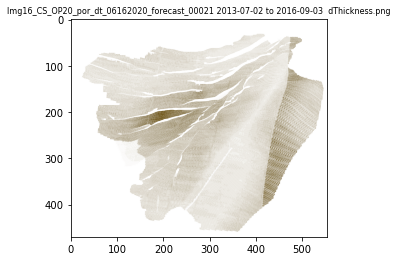


Match 0.7244450083734895


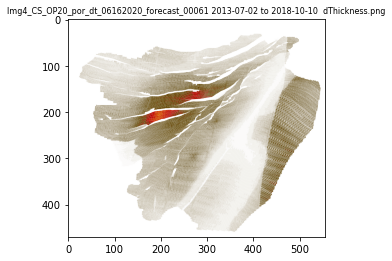


Match 0.7160338848198035


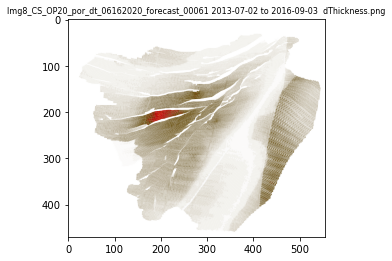


Match 0.7134370878980734


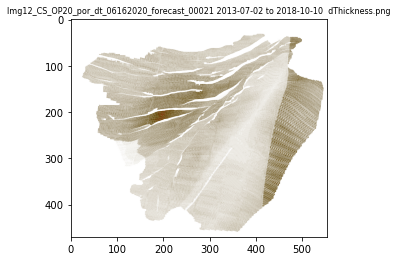

Image Distance [0.29978537 0.27555499 0.         0.27599793]

Query image ==========================================



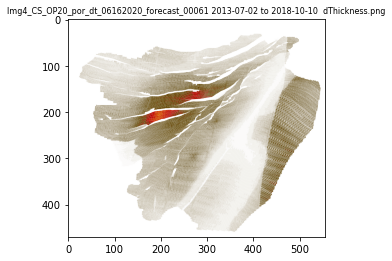


Result images ========================================


Match 1.0


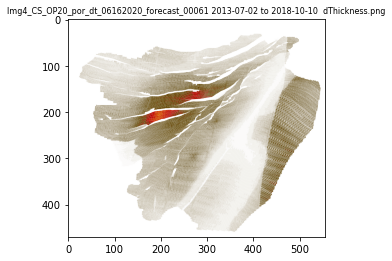


Match 0.7244450083734895


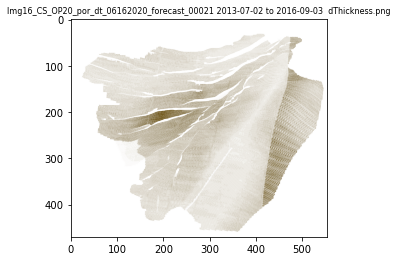


Match 0.7240020713021111


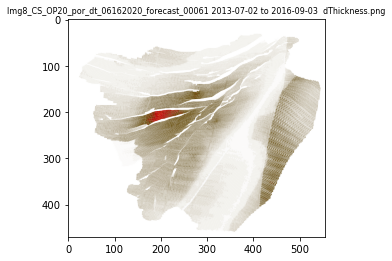


Match 0.7002146338748869


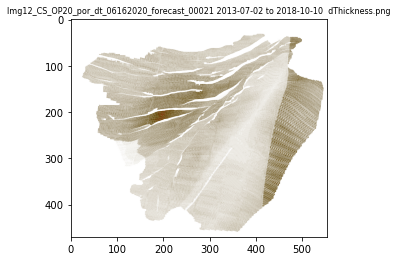

Image Distance [0.29862053 0.28396612 0.27599793 0.        ]

Query image ==========================================



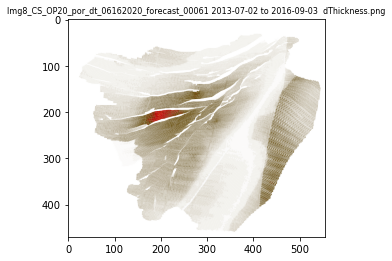


Result images ========================================


Match 1.0


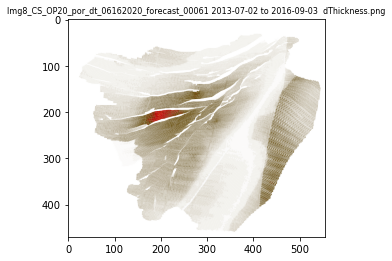


Match 0.7240020713021111


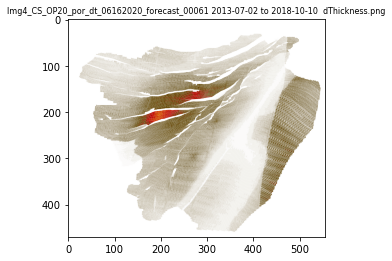


Match 0.7160338848198035


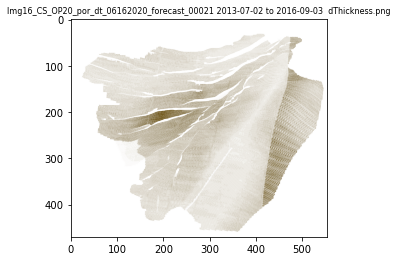


Match 0.7013794700519744


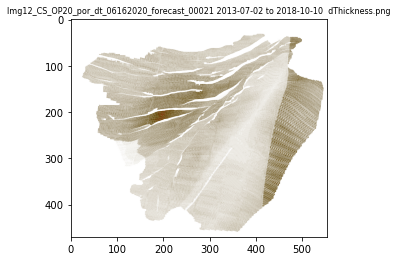

In [43]:
def show_img(path, name):
    img = imageio.imread(path)
    plt.imshow(img)
    plt.title(name, fontsize=8)
#     plt.xlabel(name, fontsize=8)
    plt.show()
    
def run():
    images_path = r'C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\Data\Seismic'
    # Reading input 
    files = [f for f in Path(images_path).glob('*dThickness.png')]
#     files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    print("FILES: \n",files)
    # getting 3 random images 
#     sample = random.sample(files, 4)
    sample = files

    print("sample :\n",sample)
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in files:
#         print("\ns:\n",s)
        names, match = ma.match(s, topn=4)
#         s=str(s)
        name = os.path.basename(s)
#         name = s.split("/")[-1].lower()
#         print("\nSAMPLES :\n", name)
        print('\nQuery image ==========================================\n')
        show_img(s, name)
        
#         print("\n NAMES",names)
        print ('\nResult images ========================================\n')
        for i in range(4):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print('\nMatch %s' % (1-match[i]))
            show_img(os.path.join(images_path, names[i]), names[i])

run()

In [2]:
selected_items=['BHP','WPT','GPT']
cum_items=['OPT','WPT','GPT']
# check =  any(item in list1 for item in list2)
list3 = [value for value in selected_items if value in cum_items]
if not list3:
    print("EMPTY")
else:
    print("Elements :",list3)

Elements : ['WPT', 'GPT']
